In [ ]:
# acc, wrong avg tokens, right avg tokens, avg flops, corrct_tokens_ratio

## time

In [1]:
import __init__
from speculative.test import *
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
size = '1.5B'
model_name = f"deepseek-ai/DeepSeek-R1-Distill-Qwen-{size}"  # or your model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")
tokenizer.pad_token = tokenizer.pad_token or tokenizer.eos_token
all_results = dict()
for n in [1, 10, 20, 125, 250]:
    results = benchmark_final_token_latency_by_prompt_len(model, tokenizer, n_generate=n)
    all_results[n] = {
        'generate_n': sum(r['generate_n'] for r in results)/len(results),
        'generate_last':  sum(r['generate_last'] for r in results)/len(results)
    }

/home/wxy320/miniconda3/envs/multio1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [5]:
all_results = dict()
for n in [1, 10, 20, 125, 250]:
    results = benchmark_final_token_latency_by_prompt_len(model, tokenizer, n_generate=n)
    all_results[n] = {
        'generate_n': sum(r['generate_n'] for r in results)/len(results),
        'generate_last':  sum(r['generate_last'] for r in results)/len(results)
    }

In [4]:
all_results

{1: {'generate_n': 0.09629842213221959, 'generate_last': 0.09423746381487165},
 10: {'generate_n': 0.8562560081481934, 'generate_last': 0.11295182364327568},
 20: {'generate_n': 1.7053992407662528, 'generate_last': 0.11483689716884068},
 125: {'generate_n': 10.588617767606463, 'generate_last': 0.12448600360325404},
 250: {'generate_n': 21.21954103878566, 'generate_last': 0.1551314081464495}}

In [6]:
# 1.5B
# all_results[20]['generate_last'] = all_results[20]['generate_last'] /10
all_results

{1: {'generate_n': 0.03650498390197754, 'generate_last': 0.03612862314496722},
 10: {'generate_n': 0.3279197556631906, 'generate_last': 0.03995847702026367},
 20: {'generate_n': 0.6523089068276542, 'generate_last': 0.04007669857570103},
 125: {'generate_n': 4.06265435900007, 'generate_last': 0.041925668716430664},
 250: {'generate_n': 8.119490044457573, 'generate_last': 0.04535712514604841}}

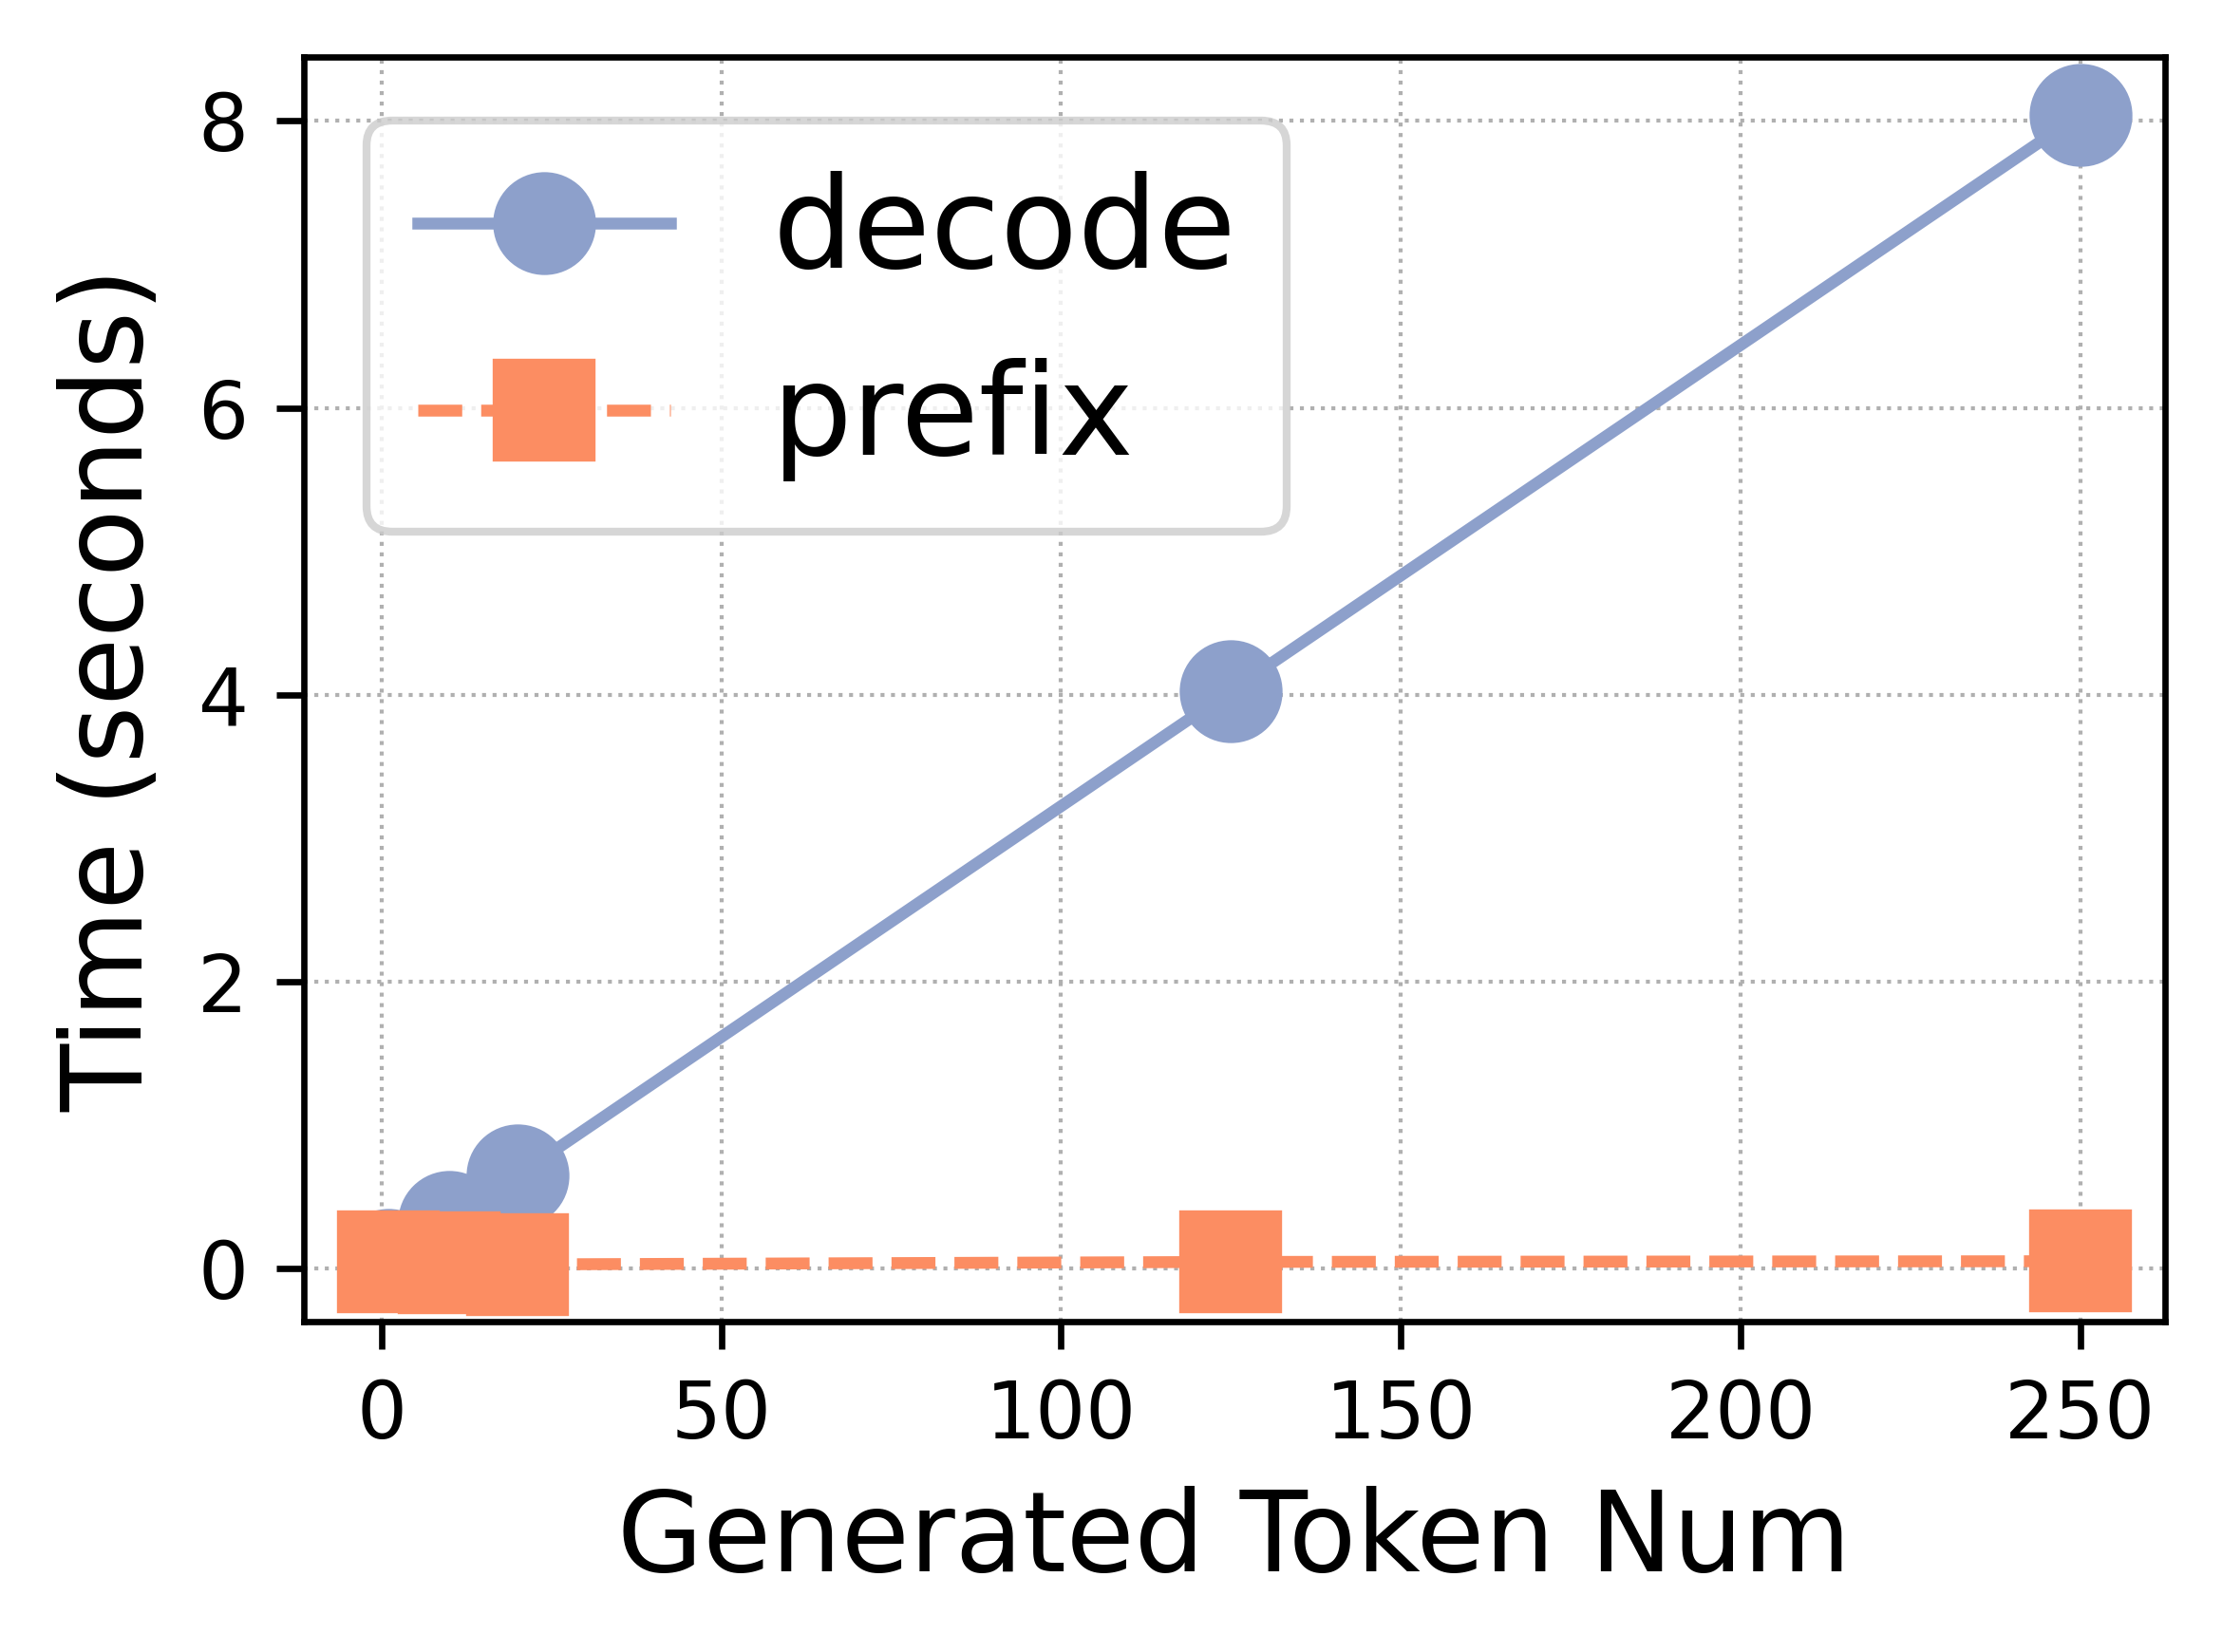

In [9]:
import matplotlib.pyplot as plt

# 数据
data = all_results

# 提取数据
x = list(data.keys())
generate_n = [data[k]['generate_n'] for k in x]
generate_last = [data[k]['generate_last'] for k in x]

# 创建图像
plt.figure(figsize=(4, 3), dpi=600)
plt.plot(x, generate_n, marker='o', linestyle='-', color='#8da0cb', label='decode', markersize=12)
plt.plot(x, generate_last, marker='s', linestyle='--', color='#fc8d62', label='prefix', markersize=12)

# 学术风格设置
plt.xlabel('Generated Token Num', fontsize=14)
plt.ylabel('Time (seconds)', fontsize=14)
# plt.title('Latency vs Key', fontsize=16)
plt.grid(True, linestyle=':', linewidth=0.5)
plt.legend(fontsize=16)
plt.tight_layout()

# 保存高分辨率图像
plt.savefig(f'latency_vs_key{size}.pdf', dpi=300)
plt.show()

### ratio

In [58]:
import re
from collections import Counter
from transformers import AutoTokenizer
import json

from transformers import AutoModelForCausalLM, AutoTokenizer, Qwen2ForCausalLM
target_model_name = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-32B'
tokenizer = AutoTokenizer.from_pretrained(target_model_name)

def show_ration(texts, model):
    # 目标关键词
    keywords = {"wait", "hmm", "alternatively"}

    # 存储关键词前 2 个 token
    collected_words = {keyword: Counter() for keyword in keywords}

    # 遍历所有结果
    for text in texts:
        
        for keyword in keywords:
            parts = re.split(rf'\b{keyword}\b', text, flags=re.IGNORECASE)
            for i in range(1, len(parts)):
                before_keyword = parts[i - 1]
                token_ids = tokenizer.encode(before_keyword)
                decoded_tokens = [tokenizer.decode([t]) for t in token_ids]
                
                for token in decoded_tokens[-1:]:
                    collected_words[keyword][token] += 1

    # 计算比率，并只保留前10个
    collected_top_ratios = {}
    for keyword, counter in collected_words.items():
        total = sum(counter.values())
        if total > 0:
            # 先转成 (token, ratio) 并排序，取前10个
            top_items = counter.most_common(10)
            top_ratios = {token: count / total for token, count in top_items}
            collected_top_ratios[keyword] = top_ratios
        else:
            collected_top_ratios[keyword] = {}

    # 保存为 JSON 文件
    output_file = f"{model}_top10_token_ratios.json"
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(collected_top_ratios, f, indent=4, ensure_ascii=False)

    print(f"Top-10 比率结果已保存至 {output_file}")

In [59]:

folder_path = "/home/wxy320/ondemand/program/speculative_thinking/analysis/1/normal"  # 替换为你的文件夹路径
json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]
for file in json_files:
    name = file.split('_')[0].split('-')[-1].lower()
    if name == '1.5b': name = '1b'
    dataset = file.split('_')[1]
    if dataset == 'math500':
        file_path = os.path.join(folder_path, file)
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        texts = [r['responses']['0.6'][0]['content'] for q, r in data.items()]
        print(name,dataset, len(texts))
        show_ration(texts, name)

1b math500 500


Token indices sequence length is longer than the specified maximum sequence length for this model (18178 > 16384). Running this sequence through the model will result in indexing errors


Top-10 比率结果已保存至 1b_top10_token_ratios.json
7b math500 500
Top-10 比率结果已保存至 7b_top10_token_ratios.json
14b math500 500
Top-10 比率结果已保存至 14b_top10_token_ratios.json
32b math500 500
Top-10 比率结果已保存至 32b_top10_token_ratios.json


## results

In [1]:
from transformers import AutoConfig
configs = {
    '1b': AutoConfig.from_pretrained('Qwen/Qwen2.5-1.5B-Instruct'),
    '1b-instruct': AutoConfig.from_pretrained('Qwen/Qwen2.5-1.5B-Instruct'),
    '7b': AutoConfig.from_pretrained('Qwen/Qwen2.5-7B-Instruct'),
    '7b-instruct': AutoConfig.from_pretrained('Qwen/Qwen2.5-7B-Instruct'),
    '14b': AutoConfig.from_pretrained('Qwen/Qwen2.5-14B-Instruct'),
    '14b-instruct': AutoConfig.from_pretrained('Qwen/Qwen2.5-14B-Instruct'),
    '32b': AutoConfig.from_pretrained('Qwen/Qwen2.5-32B-Instruct'),
    '32b-instruct': AutoConfig.from_pretrained('Qwen/Qwen2.5-32B-Instruct')
}

def many_decode_flops(p_l, s, h, h_, n):
    # return 8*s*(h^2) + 16*s*h + 4*s*p_l*h + 4*s*p_l*n + 6*s*h*h_ + 2*s*h_
    # return cum_decode_flop(p_l, s, h, h_, n)/5
    return decode_flop(p_l, h, h_, n)

def prefill_flop(s, h, h_, n):
    return 8*s*(h^2) + 16*s*h + 4*(s^2)*h + 4*(s^2)*n + 6*s*h*h_ + 2*s*h_

def decode_flop(s, h, h_, n):
    return 8*(h^2) + 16*h + 4*s*h + 4*s*n + 6*h*h_ + 2*h_

def cum_decode_flop(p_l, l, h, h_, n):
    flops = 0
    for i in range(l):
        flops = flops + decode_flop(p_l+i, h, h_, n)
    return flops

def get_flops(name, help_model, token_usages):
    correct_num = 0
    prefill_flops, prefix_flops, decode_flops=0,0,0
    if help_model not in configs.keys():
        config = configs[name]
        info= config.hidden_size, config.intermediate_size, config.num_attention_heads
        prefill_flops = prefill_flop(token_usages['prompt_tokens'], *info) 
        decode_flops = cum_decode_flop(token_usages['prompt_tokens'], token_usages['completion_tokens'], *info)
    else:
        spe_config = configs[name]
        tgt_config = configs[help_model]
        spe_info = spe_config.hidden_size, spe_config.intermediate_size, spe_config.num_attention_heads
        tgt_info = tgt_config.hidden_size, tgt_config.intermediate_size, tgt_config.num_attention_heads
        correct_tokens = token_usages['correct_tokens']
        completion_tokens = token_usages['completion_tokens']
        prompt_tokens = token_usages['prompt_tokens']
        last_spe_decode_pos = prompt_tokens
        # correct_times = len(token_usages['correct_tokens'])
        # print(token_usages['correct_tokens'])
        # print(correct_times)
        token_num = 0
        prefill_flops = prefill_flops+prefill_flop(prompt_tokens, *spe_info)
        prefill_flops = prefill_flops+prefill_flop(prompt_tokens, *tgt_info)
        for cor_t in correct_tokens:
            pos, token_num = cor_t['pos']+prompt_tokens, cor_t['token_num']
            decode_flops = decode_flops+cum_decode_flop(last_spe_decode_pos, pos-last_spe_decode_pos, *spe_info)
            f = many_decode_flops(last_spe_decode_pos, pos-last_spe_decode_pos, *tgt_info)
            prefix_flops = prefix_flops+f #*f/cum_decode_flop(last_spe_decode_pos, pos-last_spe_decode_pos, *tgt_info)
            decode_flops = decode_flops+cum_decode_flop(pos, token_num, *tgt_info)
            f = many_decode_flops(pos, token_num, *spe_info)
            prefix_flops = prefix_flops+f #*f/cum_decode_flop(pos, token_num, *spe_info)
            correct_num = correct_num + token_num
            last_spe_decode_pos = pos
        decode_flops = decode_flops+cum_decode_flop(last_spe_decode_pos+token_num, completion_tokens+prompt_tokens-last_spe_decode_pos-token_num, *spe_info)
    return prefill_flops, prefix_flops, decode_flops, correct_num


/home/wxy320/miniconda3/envs/multio1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
keywords = {"wait", "hmm", "alternatively", 'double-check'}

def segement(text):
    text = text.strip()  # 处理原始文本

    # **按 `\n\n` 进行初步分割**
    sections = re.split(r'\n\n+', text)

    # **存储最终分割的部分**
    filtered_sections = []
    temp_section = ""

    for section in sections:
        last_20_chars = section[:30].lower()  # 取后 20 个字符并转换为小写
        # print(last_20_chars)
        if any(keyword in last_20_chars for keyword in keywords):
            # 如果当前 `temp_section` 不是空的，则合并存储
            if temp_section:
                filtered_sections.append(temp_section.strip())
            temp_section = section+ "\n\n"
        else:
            # 累积无关键词的部分，等待下次匹配
            temp_section += section + "\n\n"

    # **如果最后 `temp_section` 仍有内容，加入最终结果**
    if temp_section:
        filtered_sections.append(temp_section.strip())
    return len(filtered_sections)

In [3]:
import os
import json
import math
import re

def log_flops(flops):
    # print(flops)
    if flops <= 0: return 0
    r = 312*10**8
    # print(flops/r)
    return flops/r #

def count_exact_wait_in_code(code_str):
    # count = code_str.lower().count('wait')
    count = segement(code_str.lower())
    # print(count)
    # matches = re.findall(r'\bwait\b', code_str.lower(), flags=re.IGNORECASE)
    # # print(f"'wait' 精确出现次数: {len(matches)}")
    # count = len(matches)
    return count

def get_info(data, name, help_model, t=0.6):
    correct_num, correct_tokens, worng_tokens, all_time_spend = 0, 0, 0, 0
    fix_tokens, prefill_flops, prefix_flops, decode_flops, = 0, 0, 0, 0
    right_wait_count,wrong_wait_count = 0,0
    for k in data.keys():
        response = data[k]['responses'][str(t)][0]['content']
        wait_count = count_exact_wait_in_code(response)
        token_usages = data[k]['token_usages'][str(t)][0]
        # if 'correct_tokens' not in token_usages.keys():
        #     print(token_usages.keys())
        #     print(k)
        #     print(token_usages)
        # time_spend = token_usages['time_spend']
        tokens_num = token_usages['completion_tokens']
        prefill_flop, prefix_flop, decode_flop, fix_token = get_flops(name, help_model, token_usages)
        prefill_flops = prefill_flops + prefill_flop
        prefix_flops = prefix_flops + prefix_flop
        decode_flops = decode_flops + decode_flop
        if data[k]['responses'][str(t)][0]['correctness']: 
            correct_num = correct_num+1
            correct_tokens = correct_tokens+tokens_num
            right_wait_count = right_wait_count + wait_count
        else:
            worng_tokens = worng_tokens+tokens_num
            wrong_wait_count = wrong_wait_count + wait_count
        fix_tokens = fix_tokens+fix_token
        #  all_time_spend = all_time_spend + time_spend
    all_num = len(data.keys())
    return {
        'right_wait_count': right_wait_count,
        'wrong_wait_count': wrong_wait_count,
        'all_num':all_num,
        'correct_num':correct_num,
        'wrong_num':all_num-correct_num,
        'acc':round(correct_num/all_num, 4),
        'avg_token_num': round((correct_tokens+worng_tokens)/all_num, 2),
        'correct_avg_tokens':round(correct_tokens/correct_num, 2) if correct_num != 0 else 0,
        'worng_avg_tokens':round(worng_tokens/(all_num-correct_num), 2) if all_num-correct_num != 0 else 0,
        'prefill_flops': round(log_flops(prefill_flops), 2),
        'prefix_flops': round(log_flops(prefix_flops), 2),
        'decode_flops': round(log_flops(decode_flops), 2),
        'all_tokens': correct_tokens+worng_tokens,
        't/flops': round((correct_tokens+worng_tokens)/log_flops(decode_flops+prefix_flops+prefill_flops), 2),
        'all_flops': round(log_flops(decode_flops+prefix_flops+prefill_flops), 2),
        #  'avg_time_spend': round((correct_tokens+worng_tokens)/all_time_spend, 2),
        'fix_ratio': round(fix_tokens/(correct_tokens+worng_tokens),2),
        'fix_tokens':fix_tokens
    }

In [4]:
from collections import defaultdict
results = defaultdict(dict)

aime_data = dict()
folder_path = "/home/wxy320/ondemand/program/speculative_thinking/analysis/1/normal"  # 替换为你的文件夹路径
json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]
for file in json_files:
    name = file.split('_')[0].split('-')[-1].lower()
    if name == '1.5b': name = '1b'
    dataset = file.split('_')[1]
    file_path = os.path.join(folder_path, file)
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
        result = get_info(data, name, None)
    if 'aime' in dataset:
        if name not in aime_data.keys():
            aime_data[name] = dict()
        aime_data[name].update(data)
    results[(name,dataset)] = {
        'normal': result
    }
for name, data in aime_data.items():
    result = get_info(data, name, None)
    results[(name,'aime')] = {
        'normal': result
    }

In [47]:
final_results = defaultdict(dict)
for key, r in results.items():
    # print(key)
    final_results[key[1]][key[0]]=r
for d, r in final_results.items():
    print(d)
    print('------------------------')
    for k, r_ in r.items():
        print(k)
        for k_, r_1 in r_.items():
            print(k_, r_1)
    print('------------------------')

aime22
------------------------
1b
normal {'right_wait_count': 468, 'wrong_wait_count': 3795, 'all_num': 30, 'correct_num': 9, 'wrong_num': 21, 'acc': 0.3, 'avg_token_num': 17880.17, 'correct_avg_tokens': 9296.56, 'worng_avg_tokens': 21558.86, 'prefill_flops': 11.14, 'prefix_flops': 0, 'decode_flops': 2678.71, 'all_tokens': 536405, 't/flops': 199.42, 'all_flops': 2689.85, 'fix_tokens': 0.0}
7b
normal {'right_wait_count': 847, 'wrong_wait_count': 1575, 'all_num': 30, 'correct_num': 15, 'wrong_num': 15, 'acc': 0.5, 'avg_token_num': 13042.73, 'correct_avg_tokens': 9178.8, 'worng_avg_tokens': 16906.67, 'prefill_flops': 54.92, 'prefix_flops': 0, 'decode_flops': 6876.49, 'all_tokens': 391282, 't/flops': 56.45, 'all_flops': 6931.42, 'fix_tokens': 0.0}
14b
normal {'right_wait_count': 579, 'wrong_wait_count': 1649, 'all_num': 30, 'correct_num': 18, 'wrong_num': 12, 'acc': 0.6, 'avg_token_num': 13816.97, 'correct_avg_tokens': 7878.28, 'worng_avg_tokens': 22725.0, 'prefill_flops': 57.26, 'prefix_

In [165]:
dataset = 'gpqa'
r = {'1.5B': final_results[dataset]['1b']['normal'], '32B': final_results[dataset]['32b']['normal'],
     '7B': final_results[dataset]['7b']['normal'], '14B': final_results[dataset]['14b']['normal'],}
r

{'1.5B': {'right_wait_count': 4878,
  'wrong_wait_count': 8990,
  'all_num': 198,
  'correct_num': 67,
  'wrong_num': 131,
  'acc': 0.3384,
  'avg_token_num': 7921.97,
  'correct_avg_tokens': 8556.21,
  'worng_avg_tokens': 7597.59,
  'prefill_flops': 130.01,
  'prefix_flops': 0,
  'decode_flops': 6898.53,
  'all_tokens': 1568550,
  't/flops': 223.17,
  'all_flops': 7028.54,
  'fix_tokens': 0.0},
 '32B': {'right_wait_count': 3881,
  'wrong_wait_count': 4591,
  'all_num': 198,
  'correct_num': 122,
  'wrong_num': 76,
  'acc': 0.6162,
  'avg_token_num': 5406.79,
  'correct_avg_tokens': 4481.6,
  'worng_avg_tokens': 6891.96,
  'prefill_flops': 1336.54,
  'prefix_flops': 0,
  'decode_flops': 32557.22,
  'all_tokens': 1070544,
  't/flops': 31.59,
  'all_flops': 33893.75,
  'fix_tokens': 0.0},
 '7B': {'right_wait_count': 3087,
  'wrong_wait_count': 5792,
  'all_num': 198,
  'correct_num': 90,
  'wrong_num': 108,
  'acc': 0.4545,
  'avg_token_num': 6111.45,
  'correct_avg_tokens': 5301.43,
  '

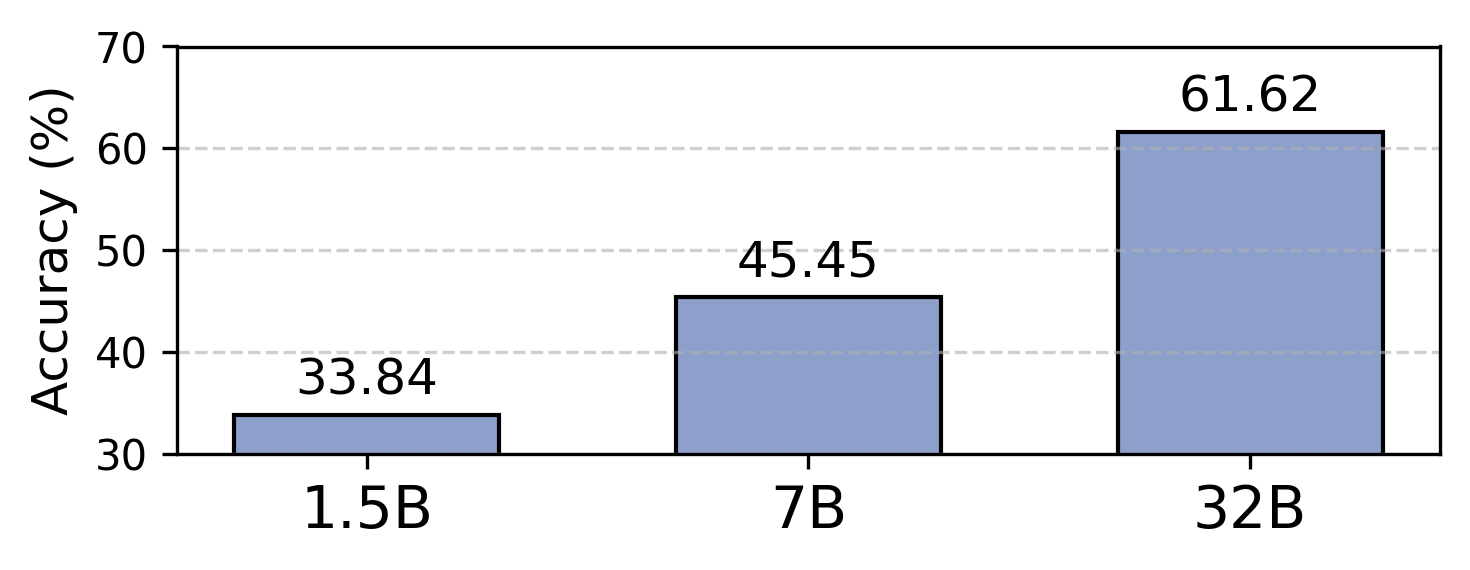

In [167]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
models = ['1.5B', '7B', '32B']
acc = [r[m]['acc'] * 100 for m in models]

# 绘图
fig, ax = plt.subplots(figsize=(5, 2), dpi=300)
x = np.arange(len(models))
bar_width = 0.6

bars = ax.bar(x, acc, width=bar_width, color='#8da0cb', edgecolor='black')
ax.set_ylabel('Accuracy (%)', fontsize=12, color='black')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=14)
ax.tick_params(axis='y', labelcolor='black')
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
if dataset == 'aime': ax.set_ylim(20, 73)
if dataset == 'math500': ax.set_ylim(80, 96)
if dataset == 'amc23': ax.set_ylim(70, 100)
if dataset == 'gpqa': ax.set_ylim(30, 70)

# 添加文字标签
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.2f}', 
            ha='center', va='bottom', fontsize=12, color='black')

# 图例
# ax.legend(['Accuracy'], loc='upper right', frameon=False, fontsize=10)

plt.tight_layout()
plt.savefig(f"comparision1_{dataset}.pdf", bbox_inches='tight')
plt.show()

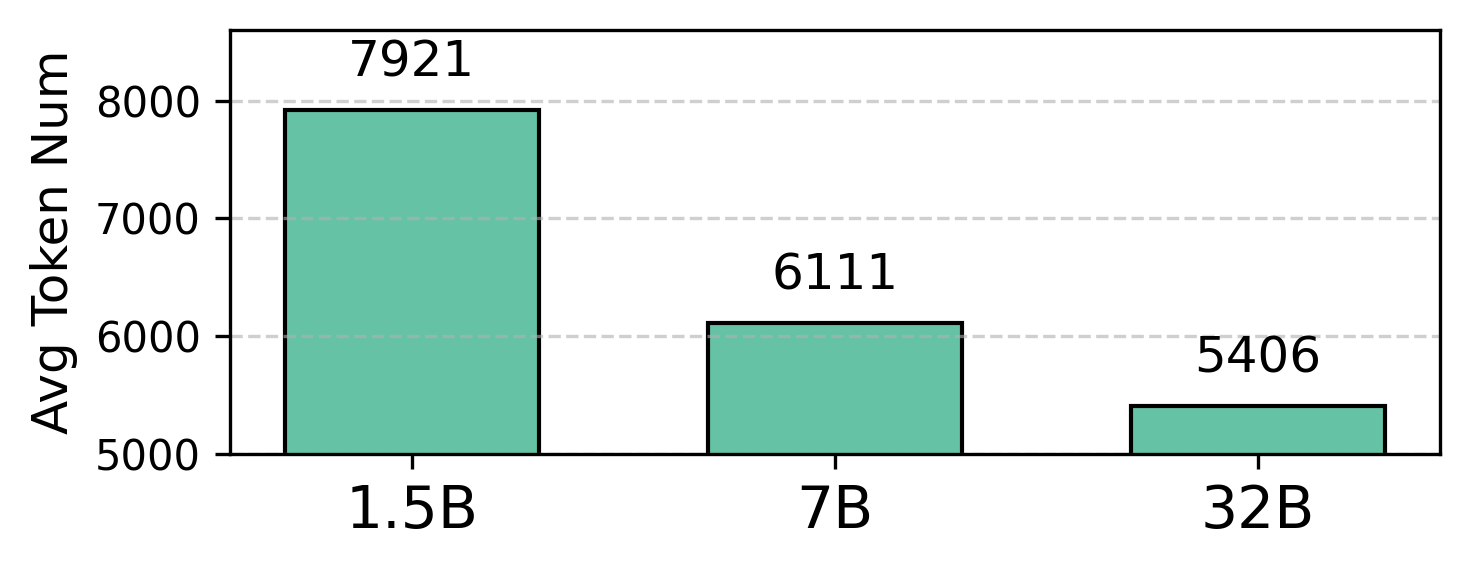

In [171]:
import matplotlib.pyplot as plt
import numpy as np

# 示例数据（继续用 r 和 dataset）
models = ['1.5B', '7B', '32B']
avg_token_num = [r[m]['avg_token_num'] for m in models]

# 绘图
fig, ax = plt.subplots(figsize=(5, 2), dpi=300)
x = np.arange(len(models))
bar_width = 0.6

bars = ax.bar(x, avg_token_num, width=bar_width, color='#66c2a5', edgecolor='black')
ax.set_ylabel('Avg Token Num', fontsize=12, color='black')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=14)
ax.tick_params(axis='y', labelcolor='black')
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
if dataset == 'aime': ax.set_ylim(11000, 19000)
if dataset == 'math500': ax.set_ylim(3500, 6000)
if dataset == 'amc23': ax.set_ylim(5800, 12000)
if dataset == 'gpqa': ax.set_ylim(5000, 8600)

# 添加文字标签
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 200, f'{int(height)}', 
            ha='center', va='bottom', fontsize=12, color='black')

# 图例
# ax.legend(['Avg Token Num'], loc='upper right', frameon=False, fontsize=10)

plt.tight_layout()
plt.savefig(f"comparision2_{dataset}.pdf", bbox_inches='tight')
plt.show()

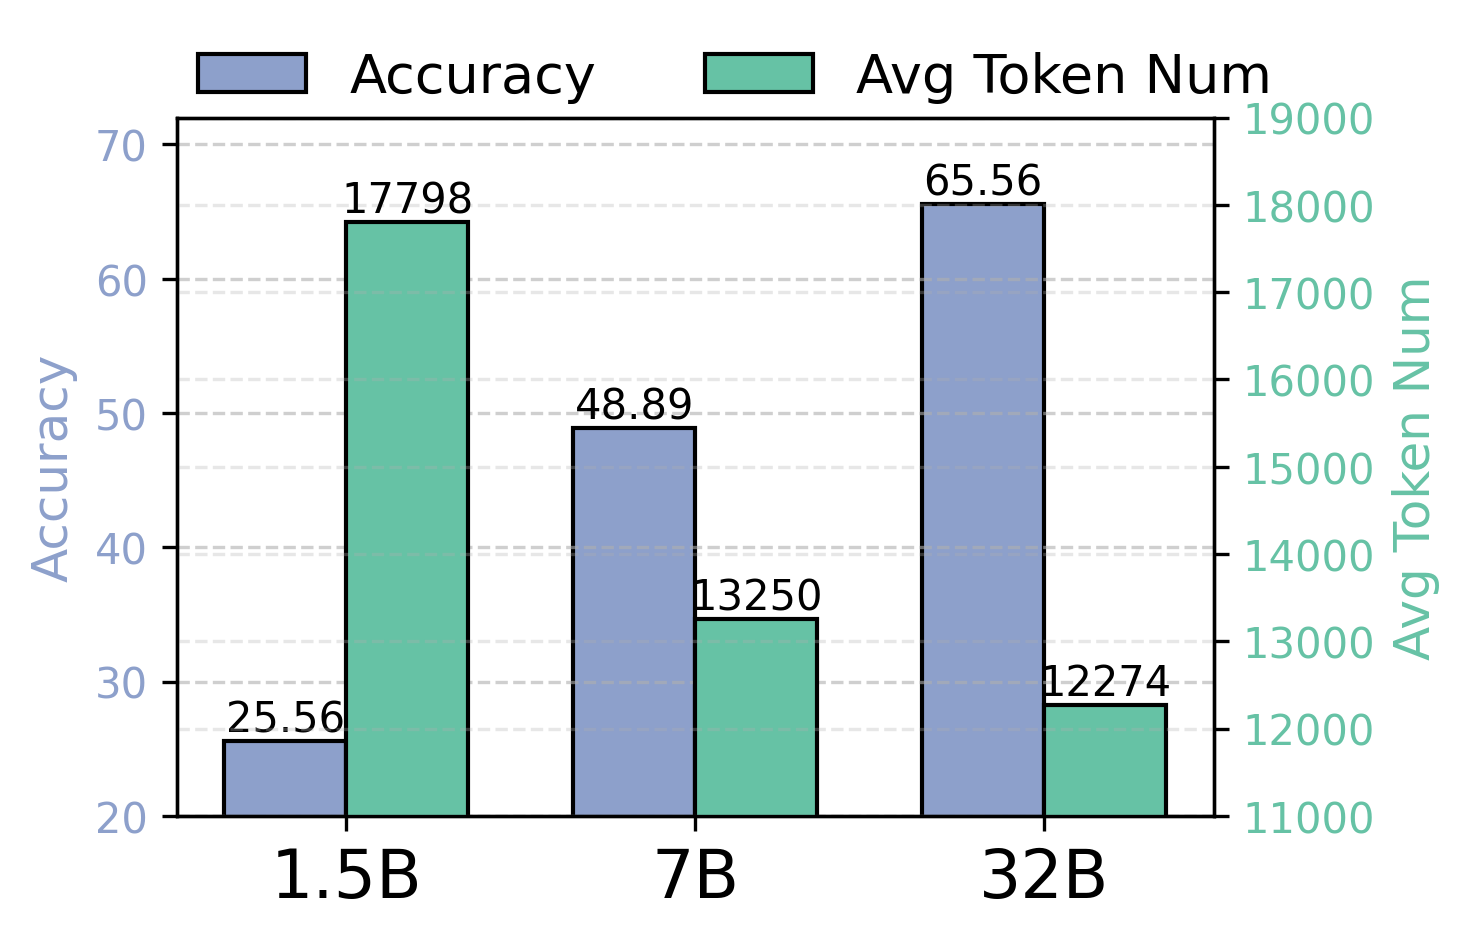

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# 示例数据（请替换为实际数据）

# 数据
models = ['1.5B', '7B', '32B']
acc = [r[m]['acc']*100 for m in models]
avg_token_num = [r[m]['avg_token_num'] for m in models]

# 设置图像尺寸和分辨率
fig, ax1 = plt.subplots(figsize=(5, 3), dpi=300)
x = np.arange(len(models))
bar_width = 0.35

# 左轴：Accuracy 柱状图 
acc_bars = ax1.bar(x - bar_width/2, acc, width=bar_width, color='#8da0cb', label='Accuracy', edgecolor='black')
ax1.set_ylabel('Accuracy', color='#8da0cb', fontsize=12)
ax1.tick_params(axis='y', labelcolor='#8da0cb')
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=16)
ax1.grid(True, axis='y', linestyle='--', alpha=0.6)
if dataset == 'aime': ax1.set_ylim(20,72)

# 为 Accuracy 柱添加文字标签
for bar in acc_bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=10, color='black')

# 右轴：Avg Token Num 柱状图
ax2 = ax1.twinx()
token_bars = ax2.bar(x + bar_width/2, avg_token_num, width=bar_width, color='#66c2a5', label='Avg Token Num', edgecolor='black')
ax2.set_ylabel('Avg Token Num', color='#66c2a5', fontsize=12)
ax2.tick_params(axis='y', labelcolor='#66c2a5')
ax2.grid(True, axis='y', linestyle='--', alpha=0.3)
if dataset == 'aime' : ax2.set_ylim(11000,19000)

# 为 Avg Token Num 柱添加文字标签
for bar in token_bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 5, f'{int(height)}', 
             ha='center', va='bottom', fontsize=10, color='black')

# 图例
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.06), ncol=2, frameon=False, fontsize=13)

plt.tight_layout()
plt.savefig(f"comparision1_{dataset}.pdf", bbox_inches='tight')
plt.show()

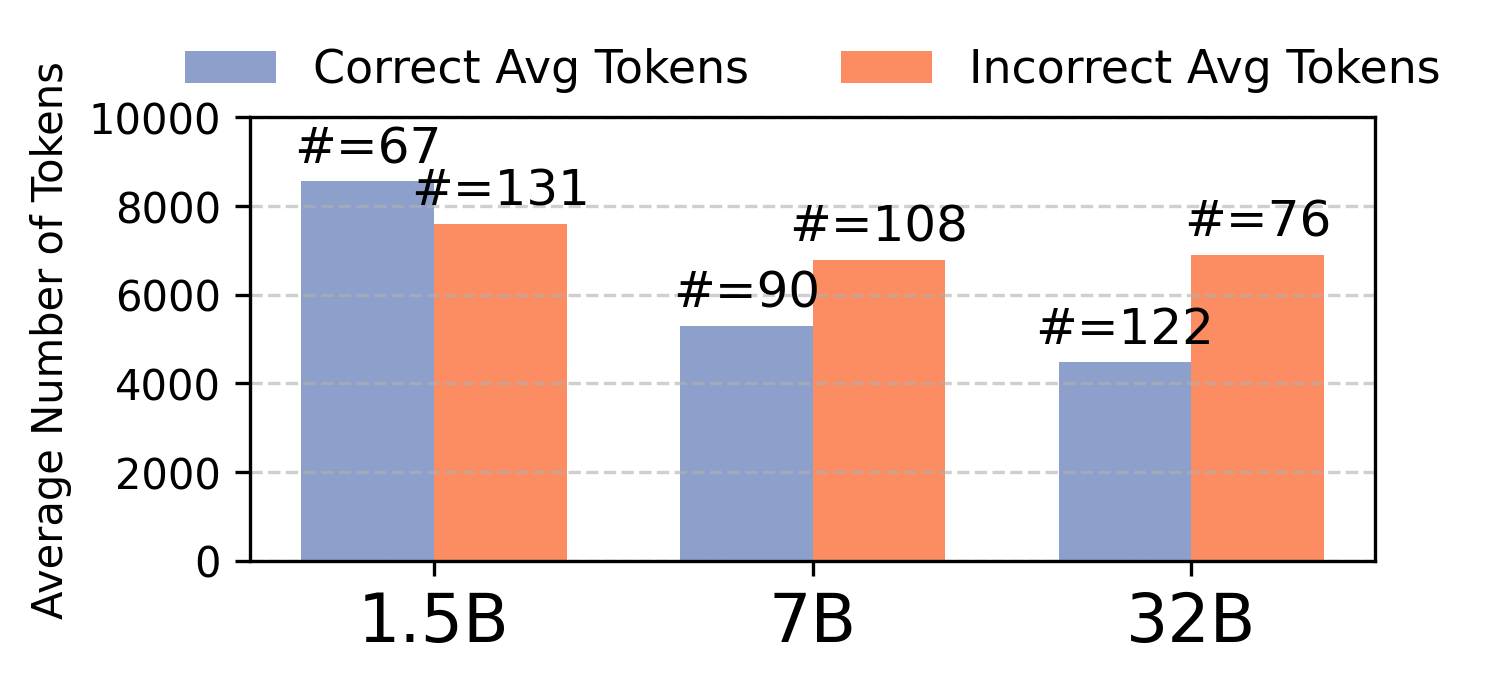

In [172]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
models = ['1.5B', '7B', '32B']
correct_avg_tokens = [r[m]['correct_avg_tokens'] for m in models]
wrong_avg_tokens = [r[m]['worng_avg_tokens'] for m in models]
correct_nums = [r[m]['correct_num'] for m in models]
wrong_nums = [r[m]['wrong_num'] for m in models]

x = np.arange(len(models))  # x轴位置
width = 0.35  # 条形图宽度

# 创建图表
fig, ax = plt.subplots(figsize=(5, 2.5), dpi=300)

# 绘制柱状图
bars1 = ax.bar(x - width/2, correct_avg_tokens, width, label='Correct Avg Tokens', color='#8da0cb')
bars2 = ax.bar(x + width/2, wrong_avg_tokens, width, label='Incorrect Avg Tokens', color='#fc8d62')

# 添加样本数量标签
for i, (c_num, w_num) in enumerate(zip(correct_nums, wrong_nums)):
    ax.text(x[i] - width/2, correct_avg_tokens[i] + 200, f'#={c_num}', ha='center', va='bottom', fontsize=12)
    ax.text(x[i] + width/2, wrong_avg_tokens[i] + 200, f'#={w_num}', ha='center', va='bottom', fontsize=12)

# 图表美化
ax.set_ylabel('Average Number of Tokens', fontsize=10)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=16)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, frameon=False, fontsize=11)
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
if dataset == 'math500': ax.set_ylim(0, 17000)
if dataset == 'aime': ax.set_ylim(0, 25000)
if dataset == 'gpqa': ax.set_ylim(0, 10000)
if dataset == 'amc23': ax.set_ylim(0, 38000)

plt.tight_layout()
plt.savefig(f"comparision3_{dataset}.pdf", bbox_inches='tight')
plt.show()

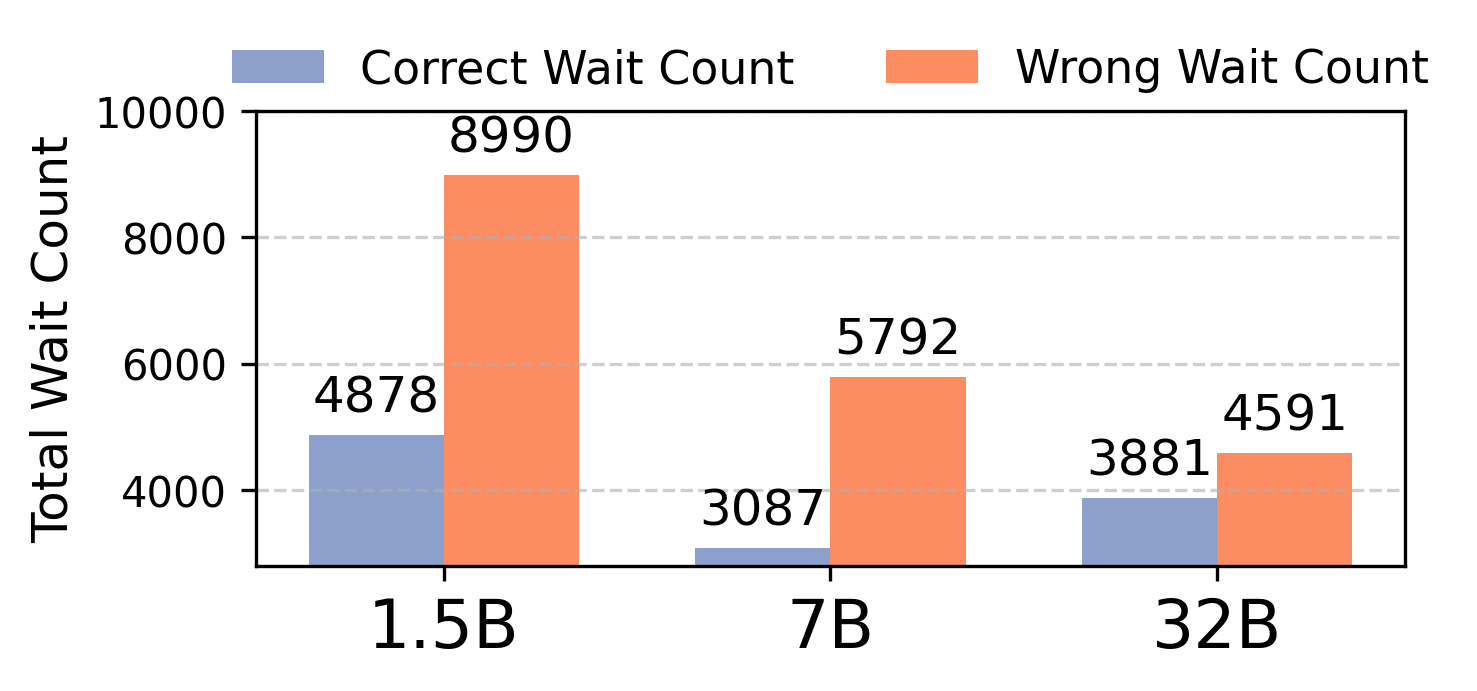

In [176]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
models = ['1.5B', '7B', '32B']
correct_avg_tokens = [r[m]['right_wait_count'] for m in models]
wrong_avg_tokens = [r[m]['wrong_wait_count'] for m in models]
correct_nums = [r[m]['correct_num'] for m in models]
wrong_nums = [r[m]['wrong_num'] for m in models]

x = np.arange(len(models))  # x轴位置
width = 0.35  # 条形图宽度

# 创建图表
fig, ax = plt.subplots(figsize=(5, 2.5), dpi=300)

# 绘制柱状图
bars1 = ax.bar(x - width/2, correct_avg_tokens, width, label='Correct Wait Count',color='#8da0cb')
bars2 = ax.bar(x + width/2, wrong_avg_tokens, width, label='Wrong Wait Count', color='#fc8d62')

# 添加样本数量标签
for i, (c_num, w_num) in enumerate(zip(correct_avg_tokens, wrong_avg_tokens)):
    ax.text(x[i] - width/2, correct_avg_tokens[i] + 200, f'{c_num}', ha='center', va='bottom', fontsize=12)
    ax.text(x[i] + width/2, wrong_avg_tokens[i] + 200, f'{w_num}', ha='center', va='bottom', fontsize=12)

# 图表美化
ax.set_ylabel('Total Wait Count', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=16)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.23), ncol=2, frameon=False, fontsize=11)
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
if dataset == 'math500': ax.set_ylim(4000, 11000)
if dataset == 'aime': ax.set_ylim(500, 12300)
if dataset == 'gpqa': ax.set_ylim(2800, 10000)
if dataset == 'amc23': ax.set_ylim(0, 2000)

plt.tight_layout()
plt.savefig(f"comparision4_{dataset}.pdf", bbox_inches='tight')
plt.show()

In [5]:
folder_path = "/home/wxy320/ondemand/program/speculative_thinking/analysis/1/speculative"  # 替换为你的文件夹路径
json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]

aime_data = dict()
for file in json_files:
    name, model, dataset = file.split('_')[0], file.split('_')[1].split('.')[0], file.split('_')[2]
    file_path = os.path.join(folder_path, file)
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
        result = get_info(data, name, model)
        # print(result)
    if 'aime' in dataset:
        # print(name, model, dataset)
        if (name, model) not in aime_data.keys():
            aime_data[(name, model)] = dict()
        aime_data[(name, model)].update(data)
    results[(name,dataset)][model] = result
for (name, model), data in aime_data.items():
    # print(name, model, len(data))
    result = get_info(data, name, model)
    results[(name,'aime')][model] = result

In [6]:
def convert_to_dataframe(final_results):
    import pandas as pd
    from collections import defaultdict

    # 示例数据（替换为你的数据）
    data = final_results

    # 转换数据格式
    def convert_to_dataframe(data):
        rows = []
        for dataset, models in data.items():
            for spec_model, targets in models.items():
                for target_model, metrics in targets.items():
                    row = {
                        'dataset': dataset,
                        'speculative_model': spec_model,
                        'target_model': target_model,
                    }
                    row.update(metrics)
                    rows.append(row)
        
        return pd.DataFrame(rows)

    # 转换为 DataFrame
    df = convert_to_dataframe(data)

    # 保存为 CSV 文件
    df.to_csv("final_result.csv", index=False)

    # 显示表格
    df.head()

In [7]:
final_results = defaultdict(dict)
for key, r in results.items():
    # print(key)
    final_results[key[1]][key[0]]=r
for d, r in final_results.items():
    print(d)
    print('------------------------')
    for k, r_ in r.items():
        print(k)
        for k_, r_1 in r_.items():
            print(k_, r_1)
    print('------------------------')

aime22
------------------------
1b
normal {'right_wait_count': 468, 'wrong_wait_count': 3795, 'all_num': 30, 'correct_num': 9, 'wrong_num': 21, 'acc': 0.3, 'avg_token_num': 17880.17, 'correct_avg_tokens': 9296.56, 'worng_avg_tokens': 21558.86, 'prefill_flops': 11.14, 'prefix_flops': 0, 'decode_flops': 2678.71, 'all_tokens': 536405, 't/flops': 199.42, 'all_flops': 2689.85, 'fix_ratio': 0.0, 'fix_tokens': 0}
14b {'right_wait_count': 423, 'wrong_wait_count': 2772, 'all_num': 30, 'correct_num': 10, 'wrong_num': 20, 'acc': 0.3333, 'avg_token_num': 17272.13, 'correct_avg_tokens': 7319.2, 'worng_avg_tokens': 22248.6, 'prefill_flops': 66.44, 'prefix_flops': 90.32, 'decode_flops': 4551.33, 'all_tokens': 518164, 't/flops': 110.06, 'all_flops': 4708.1, 'fix_ratio': 0.17, 'fix_tokens': 89645}
32b {'right_wait_count': 280, 'wrong_wait_count': 2694, 'all_num': 30, 'correct_num': 8, 'wrong_num': 22, 'acc': 0.2667, 'avg_token_num': 15866.13, 'correct_avg_tokens': 7282.12, 'worng_avg_tokens': 18987.59,

In [8]:
convert_to_dataframe(final_results)

In [9]:
final_results

defaultdict(dict,
            {'aime22': {'1b': {'normal': {'right_wait_count': 468,
                'wrong_wait_count': 3795,
                'all_num': 30,
                'correct_num': 9,
                'wrong_num': 21,
                'acc': 0.3,
                'avg_token_num': 17880.17,
                'correct_avg_tokens': 9296.56,
                'worng_avg_tokens': 21558.86,
                'prefill_flops': 11.14,
                'prefix_flops': 0,
                'decode_flops': 2678.71,
                'all_tokens': 536405,
                't/flops': 199.42,
                'all_flops': 2689.85,
                'fix_ratio': 0.0,
                'fix_tokens': 0},
               '14b': {'right_wait_count': 423,
                'wrong_wait_count': 2772,
                'all_num': 30,
                'correct_num': 10,
                'wrong_num': 20,
                'acc': 0.3333,
                'avg_token_num': 17272.13,
                'correct_avg_tokens': 7319.2,
       

In [12]:
import matplotlib.pyplot as plt

def get_draw_results(final_results, dataset):
    draw_results = dict()
    for model, r in final_results[dataset].items():
        if model != '14b':
            draw_results[(model, 'normal')] = r['normal']
            if '32b' in r.keys():
                draw_results[(model, '32b')] = r['32b']
    return draw_results

def draw(draw_results, dataset, legend=False):
    # 数据：键为(基础模型, 变体)，值为性能指标
    data = draw_results

    # 颜色映射：基础模型大小
    color_map = {'1b': '#1f77b4', '7b': '#ff7f0e', '14b': '#2ca02c', '32b': '#d62728'}
    # marker 映射：模型类型（normal, 32b）
    marker_map = {'normal': 'o', '32b': '*'}

    # 绘图
    plt.figure(figsize=(4, 3), dpi=400)
    for (base, variant), metrics in data.items():
        color = color_map[base]
        marker = marker_map.get(variant, 'x')
        plt.scatter(metrics['avg_token_num'], metrics['acc'],
                    color=color,
                    marker=marker,
                    s=300,
                    edgecolor='black',
                    label=f"spe:{base}, tgt:{variant}")

    # 画红色箭头：从 normal → 32b
    for base in ['1b', '7b']:
        normal_key = (base, 'normal')
        upgrade_key = (base, '32b')
        if normal_key in data and upgrade_key in data:
            x1, y1 = data[normal_key]['avg_token_num'], data[normal_key]['acc']
            x2, y2 = data[upgrade_key]['avg_token_num'], data[upgrade_key]['acc']
            plt.annotate("",
                         xy=(x2, y2),
                         xytext=(x1, y1),
                         arrowprops=dict(arrowstyle="->", color="red", lw=3))

    # 去重图例
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    if legend: plt.legend(unique.values(), unique.keys(), fontsize=11)

    # 学术风格图形美化
    plt.xlabel("Speed (Tokens/FLOP)", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"{dataset}.pdf", bbox_inches='tight')
    plt.show()

In [9]:
draw_results = get_draw_results(final_results, 'gpqa')
draw_results

{('1b', 'normal'): {'all_num': 198,
  'correct_num': 67,
  'wrong_num': 131,
  'acc': 0.3384,
  'avg_token_num': 7921.97,
  'correct_avg_tokens': 8556.21,
  'worng_avg_tokens': 7597.59,
  'prefill_flops': 12.61,
  'prefix_flops': 0,
  'decode_flops': 14.33,
  't/flops': 109375.07,
  'all_flops': 14.34,
  'fix_tokens': 0.0},
 ('1b', '32b'): {'all_num': 198,
  'correct_num': 83,
  'wrong_num': 115,
  'acc': 0.4192,
  'avg_token_num': 7612.36,
  'correct_avg_tokens': 6757.04,
  'worng_avg_tokens': 8229.69,
  'prefill_flops': 13.65,
  'prefix_flops': 12.78,
  'decode_flops': 14.66,
  't/flops': 102494.73,
  'all_flops': 14.71,
  'fix_tokens': 0.17},
 ('7b', 'normal'): {'all_num': 198,
  'correct_num': 90,
  'wrong_num': 108,
  'acc': 0.4545,
  'avg_token_num': 6111.45,
  'correct_avg_tokens': 5301.43,
  'worng_avg_tokens': 6786.46,
  'prefill_flops': 13.3,
  'prefix_flops': 0,
  'decode_flops': 14.77,
  't/flops': 81850.71,
  'all_flops': 14.78,
  'fix_tokens': 0.0},
 ('7b', '32b'): {'all_

In [10]:
draw_results = get_draw_results(final_results, 'math500')
draw_results

{('1b', 'normal'): {'all_num': 500,
  'correct_num': 416,
  'wrong_num': 84,
  'acc': 0.832,
  'avg_token_num': 5439.13,
  'correct_avg_tokens': 3520.69,
  'worng_avg_tokens': 14939.94,
  'prefill_flops': 12.59,
  'prefix_flops': 0,
  'decode_flops': 14.54,
  't/flops': 186990.84,
  'all_flops': 14.54,
  'fix_tokens': 0.0},
 ('1b', '32b'): {'all_num': 500,
  'correct_num': 447,
  'wrong_num': 53,
  'acc': 0.894,
  'avg_token_num': 4582.78,
  'correct_avg_tokens': 3563.96,
  'worng_avg_tokens': 13175.55,
  'prefill_flops': 13.63,
  'prefix_flops': 13.02,
  'decode_flops': 14.83,
  't/flops': 154131.47,
  'all_flops': 14.87,
  'fix_tokens': 0.19},
 ('7b', 'normal'): {'all_num': 500,
  'correct_num': 464,
  'wrong_num': 36,
  'acc': 0.928,
  'avg_token_num': 3975.21,
  'correct_avg_tokens': 3245.22,
  'worng_avg_tokens': 13384.03,
  'prefill_flops': 13.29,
  'prefix_flops': 0,
  'decode_flops': 14.98,
  't/flops': 132608.47,
  'all_flops': 14.99,
  'fix_tokens': 0.0},
 ('7b', '32b'): {'al

In [11]:
draw_results = get_draw_results(final_results, 'aime')
draw_results

{('1b', 'normal'): {'all_num': 90,
  'correct_num': 23,
  'wrong_num': 67,
  'acc': 0.2556,
  'avg_token_num': 17798.4,
  'correct_avg_tokens': 7861.35,
  'worng_avg_tokens': 21209.63,
  'prefill_flops': 11.99,
  'prefix_flops': 0,
  'decode_flops': 14.4,
  't/flops': 111237.97,
  'all_flops': 14.4,
  'fix_tokens': 0.0},
 ('1b', '32b'): {'all_num': 90,
  'correct_num': 29,
  'wrong_num': 61,
  'acc': 0.3222,
  'avg_token_num': 15706.06,
  'correct_avg_tokens': 7881.41,
  'worng_avg_tokens': 19425.97,
  'prefill_flops': 13.03,
  'prefix_flops': 12.85,
  'decode_flops': 14.69,
  't/flops': 96109.69,
  'all_flops': 14.71,
  'fix_tokens': 0.19},
 ('7b', 'normal'): {'all_num': 90,
  'correct_num': 44,
  'wrong_num': 46,
  'acc': 0.4889,
  'avg_token_num': 13250.43,
  'correct_avg_tokens': 8441.98,
  'worng_avg_tokens': 17849.83,
  'prefill_flops': 12.68,
  'prefix_flops': 0,
  'decode_flops': 14.82,
  't/flops': 80469.61,
  'all_flops': 14.82,
  'fix_tokens': 0.0},
 ('7b', '32b'): {'all_num

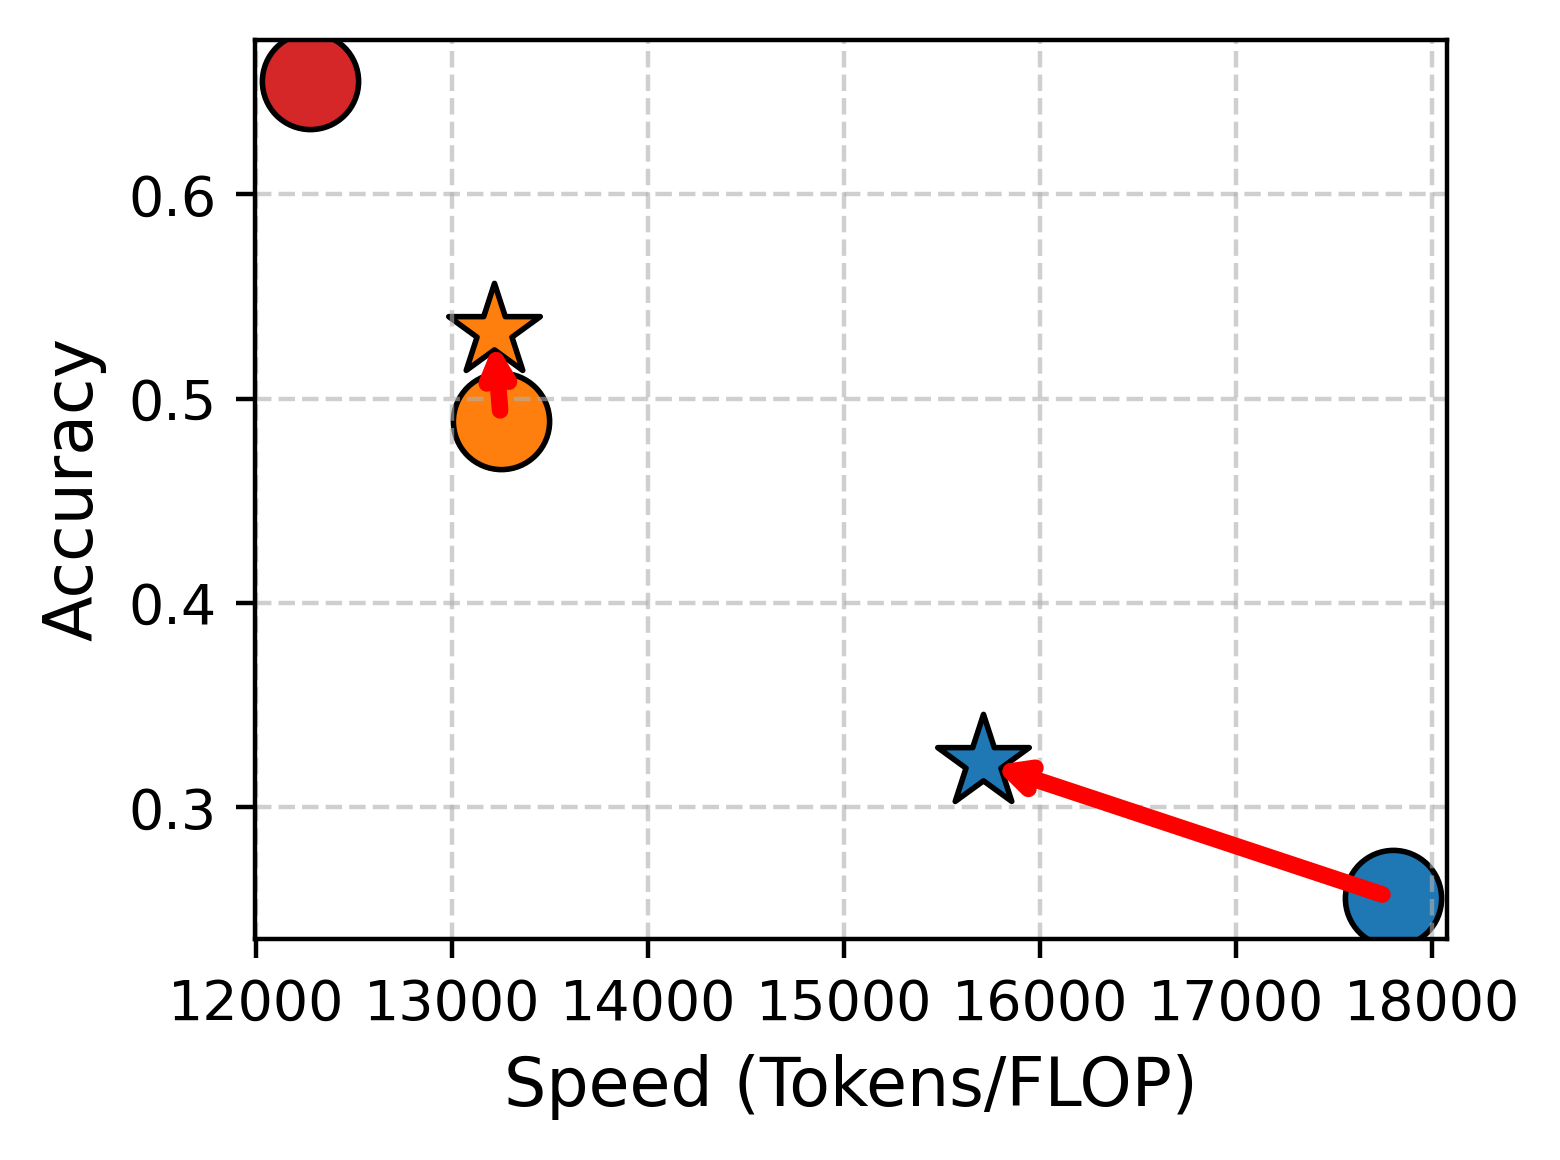

In [13]:
draw_results = get_draw_results(final_results, 'aime')
draw(draw_results, 'aime')

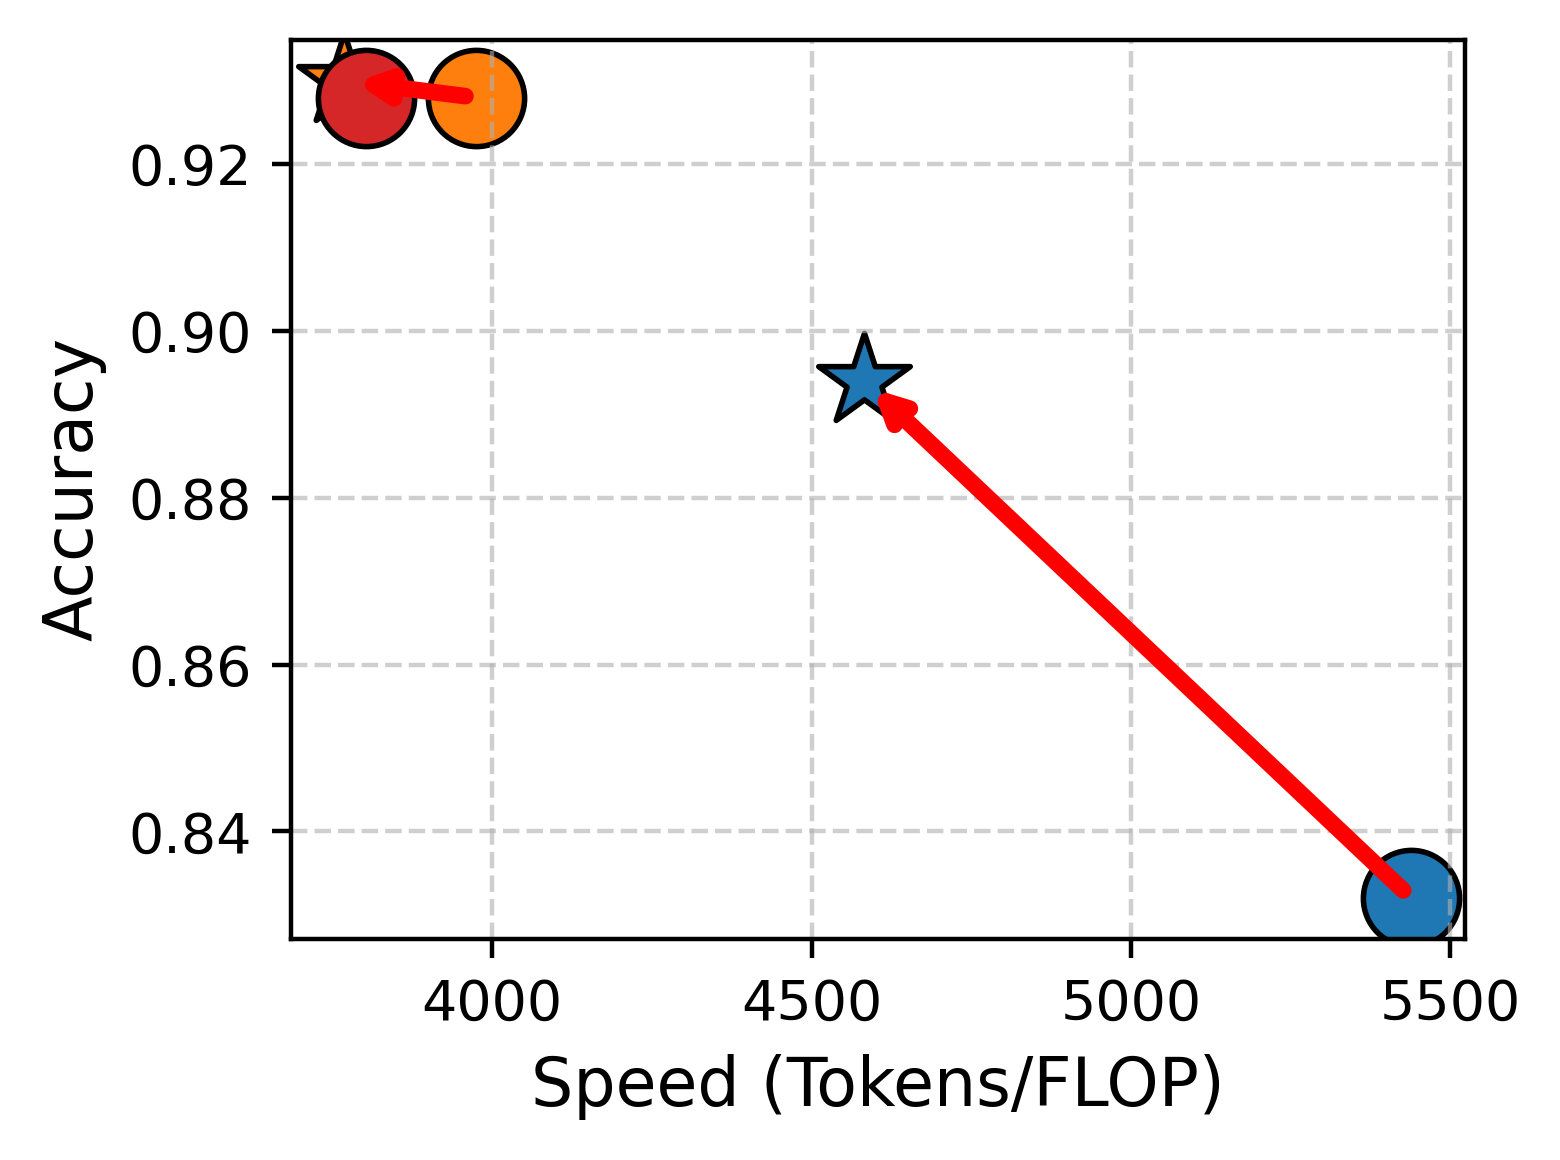

In [14]:
draw_results = get_draw_results(final_results, 'math500')
draw(draw_results,  'math500')

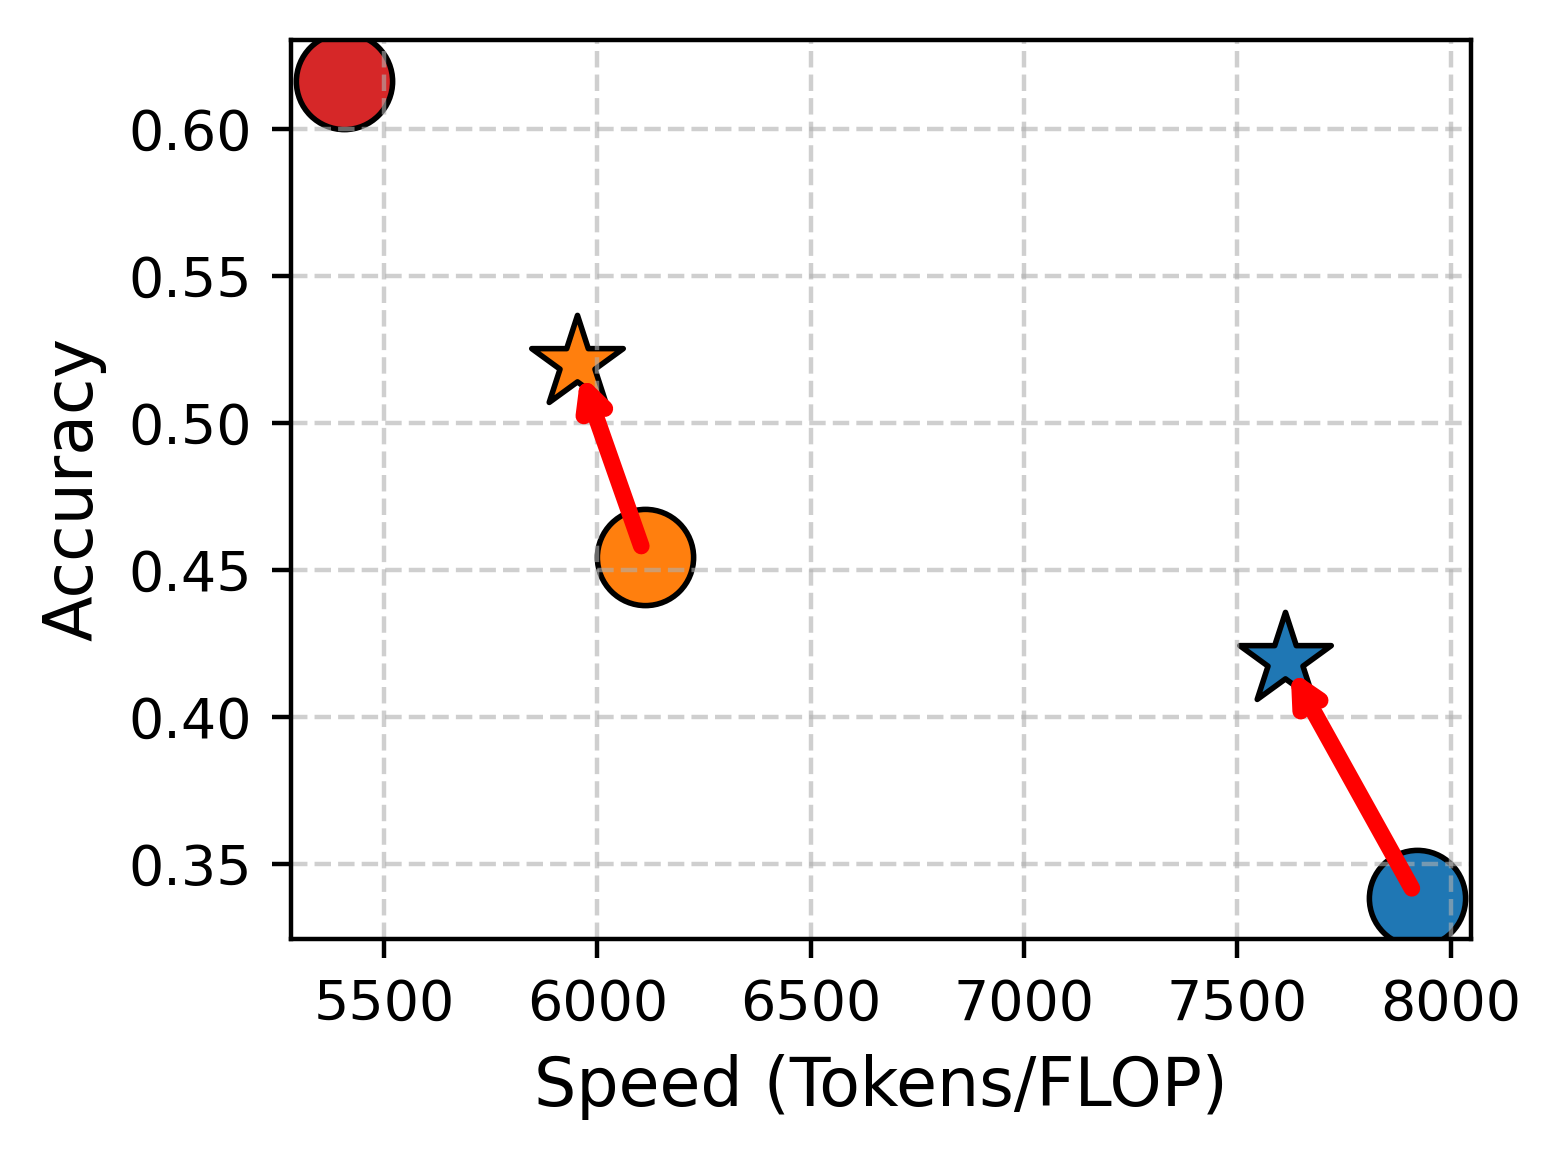

In [15]:
draw_results = get_draw_results(final_results, 'gpqa')
draw(draw_results, 'gpqa')

In [10]:
from collections import defaultdict
results = defaultdict(dict)

folder_path = "/home/wxy320/ondemand/program/speculative_thinking/analysis/instruct/normal"  # 替换为你的文件夹路径
json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]
aime_data = dict()
for file in json_files:
    name = file.split('_')[0].split('-')[-2].lower()
    if name == '1.5b': name = '1b'
    dataset = file.split('_')[1]
    file_path = os.path.join(folder_path, file)
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
        result = get_info(data, name, None)
    if 'aime' in dataset:
        if name not in aime_data.keys():
            aime_data[name] = dict()
        aime_data[name].update(data)
    results[(name,dataset)] = {
        'normal': result
    }
for name, data in aime_data.items():
    result = get_info(data, name, None)
    results[(name,'aime')] = {
        'normal': result
    }

In [11]:
folder_path = "/home/wxy320/ondemand/program/speculative_thinking/analysis/instruct/speculative"  # 替换为你的文件夹路径
json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]
aime_data = dict()
for file in json_files:
    name, model, dataset = file.split('_')[0], file.split('_')[1].split('.')[0], file.split('_')[2]
    if 'instruct' in name: name = name.split('-')[0]
    file_path = os.path.join(folder_path, file)
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
        result = get_info(data, name, model)
        # print(result)
    if 'aime' in dataset:
        # print(name, model, dataset)
        if (name, model) not in aime_data.keys():
            aime_data[(name, model)] = dict()
        aime_data[(name, model)].update(data)
    results[(name,dataset)][model] = result
for (name, model), data in aime_data.items():
    # print(name, model, len(data))
    result = get_info(data, name, model)
    results[(name,'aime')][model] = result

In [12]:
final_results = defaultdict(dict)
for key, r in results.items():
    # print(key)
    final_results[key[1]][key[0]]=r
for d, r in final_results.items():
    print(d)
    print('------------------------')
    for k, r_ in r.items():
        print(k)
        for k_, r_1 in r_.items():
            print(k_, r_1)
    print('------------------------')

aime22
------------------------
1b
normal {'right_wait_count': 0, 'wrong_wait_count': 30, 'all_num': 30, 'correct_num': 0, 'wrong_num': 30, 'acc': 0.0, 'avg_token_num': 1954.3, 'correct_avg_tokens': 0, 'worng_avg_tokens': 1954.3, 'prefill_flops': 13.52, 'prefix_flops': 0, 'decode_flops': 265.52, 'all_tokens': 58629, 't/flops': 210.11, 'all_flops': 279.04, 'fix_ratio': 0.0, 'fix_tokens': 0}
7b {'right_wait_count': 740, 'wrong_wait_count': 3398, 'all_num': 30, 'correct_num': 5, 'wrong_num': 25, 'acc': 0.1667, 'avg_token_num': 15305.17, 'correct_avg_tokens': 18455.2, 'worng_avg_tokens': 14675.16, 'prefill_flops': 64.17, 'prefix_flops': 147.43, 'decode_flops': 5119.97, 'all_tokens': 459155, 't/flops': 86.12, 'all_flops': 5331.58, 'fix_ratio': 0.36, 'fix_tokens': 163910}
32b {'right_wait_count': 55, 'wrong_wait_count': 3239, 'all_num': 30, 'correct_num': 2, 'wrong_num': 28, 'acc': 0.0667, 'avg_token_num': 15376.7, 'correct_avg_tokens': 4298.5, 'worng_avg_tokens': 16168.0, 'prefill_flops': 1

In [13]:
convert_to_dataframe(final_results)